<h1 style="font-family: Impact, Charcoal, sans-serif; padding: 12px; font-size: 30px; color: #8b4513; text-align: center; line-height: 1.25;">Sentiment Analysis<br><span style="color: #800000; font-size: 48px"><b>TripAdvisor Hotel Reviews</b></span><br><span style="color: #a0522d; font-size: 20px">Using Sklearn and Tensorflow</span></h1>

<div style="display: flex; justify-content: center;">
  <img src="assets/review.png" alt="Hotel Review" style="width:200px;">
</div>

<p>Data source: <a href="https://www.kaggle.com/datasets/thedevastator/tripadvisor-hotel-reviews">TripAdvisor Hotel Reviews</a></p>


<h1><b><span style="color: #8b4513; font-size: 28px">TABLE OF CONTENTS</span></b></h1>

* [Importing Libraries](#1)
* [Loading Dataset](#2)
* [Text Preprocessing](#3)
    * [Clean Text](#3.1)
* [Data Visualization](#4)
* [Building Model with Sklearn](#5)
    * [Make Predictions](#5.1)
    * [Prediction Interpretability using SHAP Values](#5.2)
* [Building Model with Tensorflow](#6)
* [Prediction](#7)

<a id="1"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Importing Libraries</span></b></h1>


In [1]:
import numpy as np # for array, linear algebra
import pandas as pd # for data processing
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import string

# Preprocessing and evaluation
import nltk
from nltk.stem import WordNetLemmatizer # lemmatize a word
from nltk.corpus import stopwords
from nltk.corpus import wordnet # large lexical database of English words
from wordcloud import WordCloud # to visualize text
from sklearn.feature_extraction.text import TfidfVectorizer # converts a collection of raw documents into a matrix
nltk.download('punkt')


# Models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
#import optuna
from xgboost import XGBClassifier
import shap


[nltk_data] Downloading package punkt to /Users/eo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/anaconda3/envs/nlp/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/anaconda3/envs/nlp/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprec

<a id="2"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Loading Dataset</span></b></h1>

In [2]:
df = pd.read_csv('data/trip_advisor_reviews.csv', encoding = 'ISO-8859-1')
df.columns = df.columns.str.lower()
df.head()

,s.no.,review,rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s.no.   20491 non-null  int64 
 1   review  20491 non-null  object
 2   rating  20491 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 480.4+ KB


In [4]:
df = df.sample(frac = 0.5, replace = False, random_state=42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10246 entries, 10726 to 15331
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s.no.   10246 non-null  int64 
 1   review  10246 non-null  object
 2   rating  10246 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 320.2+ KB


In [6]:
#This column is the same as index
df = df.drop(['s.no.'], axis = 1)

In [7]:
df.isna().sum()

review    0
rating    0
dtype: int64

In [8]:
df.duplicated().sum()

0

<a id="3"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Text Preprocessing</span></b></h1>
- For this dataset, we categorize all 5 and 4 stars reviews as a Good Review, the 3 start review as Neutral while all reviews from 2-star to 1-star, we categorize it as Bad Review.

In [9]:
def rating(score):
    if score >= 4:
        return 'good'
    else:
        return 'bad'

In [10]:
df['score'] = df['rating'].apply(rating)

In [11]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

In [12]:
df['review_length'] = df['review'].apply(count_chars)
df['words_count'] = df['review'].apply(count_words)

In [13]:
df.head()

,review,rating,score,review_length,words_count
10726,not recommend hotel did reviewers actually sta...,1,bad,312,46
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,good,2479,358
19098,ok hotel good location stayed night way beijin...,3,bad,164,25
2450,great service nice pool ok beach lovely ground...,4,good,2059,318
960,surprising treat spent weekend july 15/16 2006...,5,good,689,96


In [14]:
length = df['review_length'].sum()
print(f'Total words in the dataset before cleaning: {length}')

Total words in the dataset before cleaning: 7418393


<a id="3.1"></a>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Clean up the text</b></h1>

<ul>
  <li>Remove 'empty' reviews and words with only 1 letter</li>
  <li>Lowercase all text</li>
  <li>Tokenize and split text into words</li>
  <li>Remove stop words ('a', 'an', 'the', 'of', 'in', etc.)</li>
  <li>Lemmatize the text: transform every word into its root form</li>
</ul>


In [15]:
def clean_text(text):
    # Remove \t
    text = text.replace('\t', '')

    # Lowercase text
    text = text.lower()

    # Tokenize text into sentences
    sentences = nltk.sent_tokenize(text)

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    cleaned_sentences = []
    for sentence in sentences:
        # Tokenize sentence into words
        words = nltk.word_tokenize(sentence)

        # Remove punctuation and words with numbers
        words = [word.strip(string.punctuation) for word in words if not any(c.isdigit() for c in word)]

        # Remove empty tokens and stopwords
        words = [word for word in words if len(word) > 0 and word not in stopwords.words('english')]

        # Lemmatize words
        lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]

        cleaned_sentence = ' '.join(lemmatized_words)
        cleaned_sentences.append(cleaned_sentence)

    return ' '.join(cleaned_sentences)

In [16]:
df['clean_review'] = df['review'].apply(clean_text)

In [17]:
new_length = df['clean_review'].apply(len).sum()

print(f'Total words in the dataset before cleaning: {length}')
print(f'Total words in the dataset after cleaning: {new_length}')

Total words in the dataset before cleaning: 7418393
Total words in the dataset after cleaning: 6698824


In [18]:
df.head()

,review,rating,score,review_length,words_count,clean_review
10726,not recommend hotel did reviewers actually sta...,1,bad,312,46,recommend hotel reviewers actually stay hotel ...
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,good,2479,358,barcelona rock stay hotel jazz girlfriend nigh...
19098,ok hotel good location stayed night way beijin...,3,bad,164,25,ok hotel good location stay night way beijing ...
2450,great service nice pool ok beach lovely ground...,4,good,2059,318,great service nice pool ok beach lovely ground...
960,surprising treat spent weekend july 15/16 2006...,5,good,689,96,surprise treat spend weekend july cartwright h...


In [19]:
df.to_csv('df_cleaned.csv', index=False)

<a id="1"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Data Visualization</span></b></h1>

In [20]:
rating_proportions = df['rating'].value_counts(normalize=True).sort_index()

fig = px.bar(rating_proportions, x=rating_proportions.index, y=rating_proportions.values,
             hover_data=[rating_proportions.values], color=rating_proportions.index,
             height=400)

fig.update_layout(
    xaxis_title='Rating',
    yaxis_title='Proportion',
    title={
        'text': '<b>Hotel Review Rating Proportions</b>',
        'font': {'size': 24, 'color': '#8b4513'},
        'x': 0.5,  
        'xanchor': 'center'  
    },
    plot_bgcolor='white'
)

fig.update_traces(marker_coloraxis=None)

fig.show()


<p>
<strong>Ratings Breakdown:</strong><br>
1 star: 7.03%<br>
2 stars: 8.51%<br>
3 stars: 10.49%<br>
4 stars: 30.70%<br>
5 stars: 43.27%
</p>
<p>
The majority of TripAdvisor hotel reviews (43.27%) are rated with 5 stars, indicating a high level of satisfaction. Additionally, 4-star ratings hold a significant proportion (30.70%). Lower ratings (1 to 3 stars) represent a smaller proportion of the reviews.
</p>


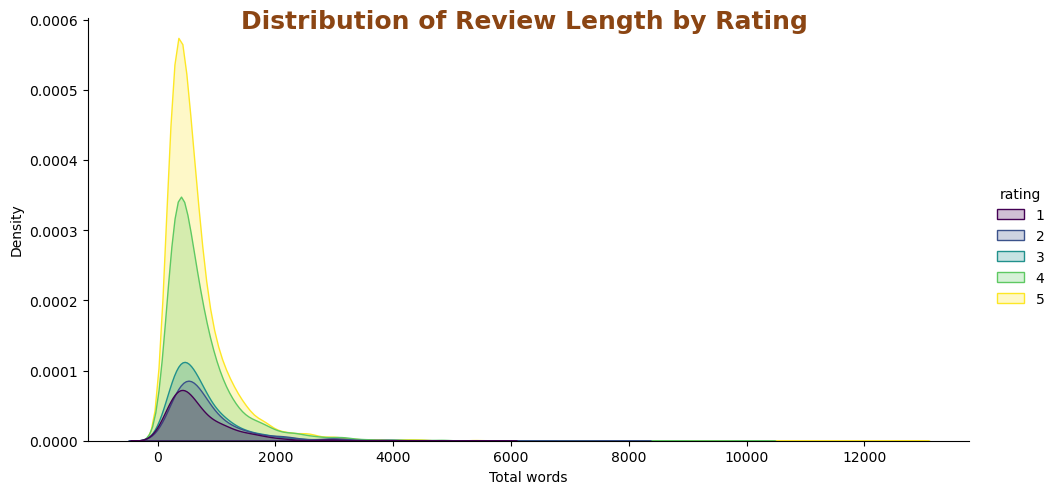

In [21]:
plot = sns.displot(data=df, x='review_length', hue='rating', palette='viridis', kind='kde', fill=True, aspect=2)

plt.suptitle('Distribution of Review Length by Rating', fontweight='bold', fontsize=18, color='#8b4513')
plot.set(xlabel='Total words', ylabel='Density')
plt.show()

In [22]:
from PIL import Image

def wordCloud_generator(data, color, color_map):
    wave_mask = np.array(Image.open('assets/cloud.png'))
    wordcloud = WordCloud(width=1000, height=1000,
                          background_color=color,
                          min_font_size=12,
                          colormap=color_map,
                          mask=wave_mask
                          ).generate(' '.join(data['clean_review'].values))
    
    # plot the WordCloud image
    plt.figure(figsize=(10, 10), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    plt.show()


In [23]:
df_good = df[df['score'].isin(['good'])][['clean_review']]
df_bad = df[df['score'] == 'bad'][['clean_review']]

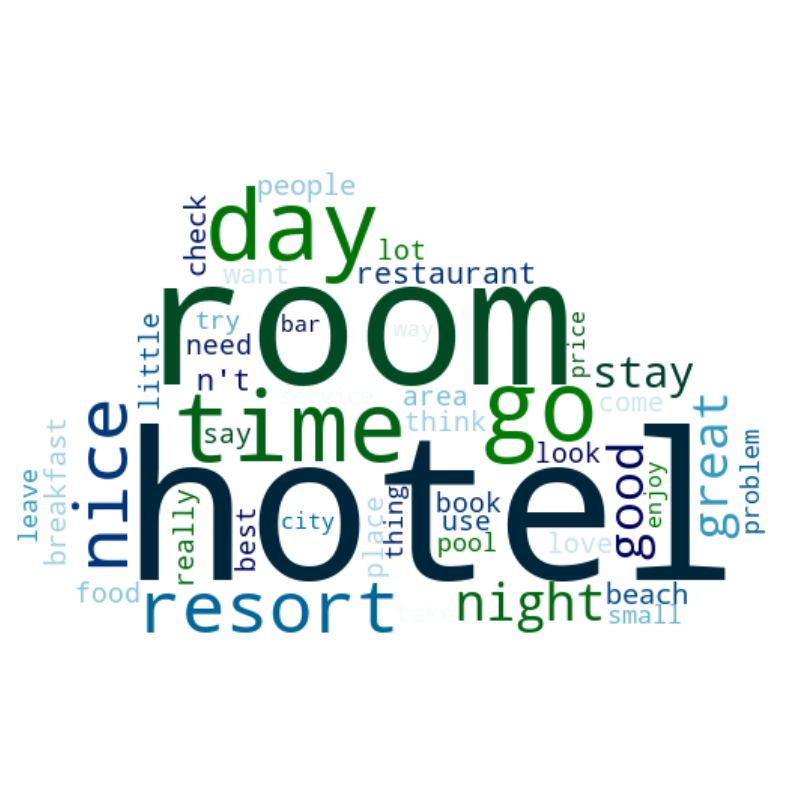

In [24]:
wordCloud_generator(df_good, 'white', 'ocean')

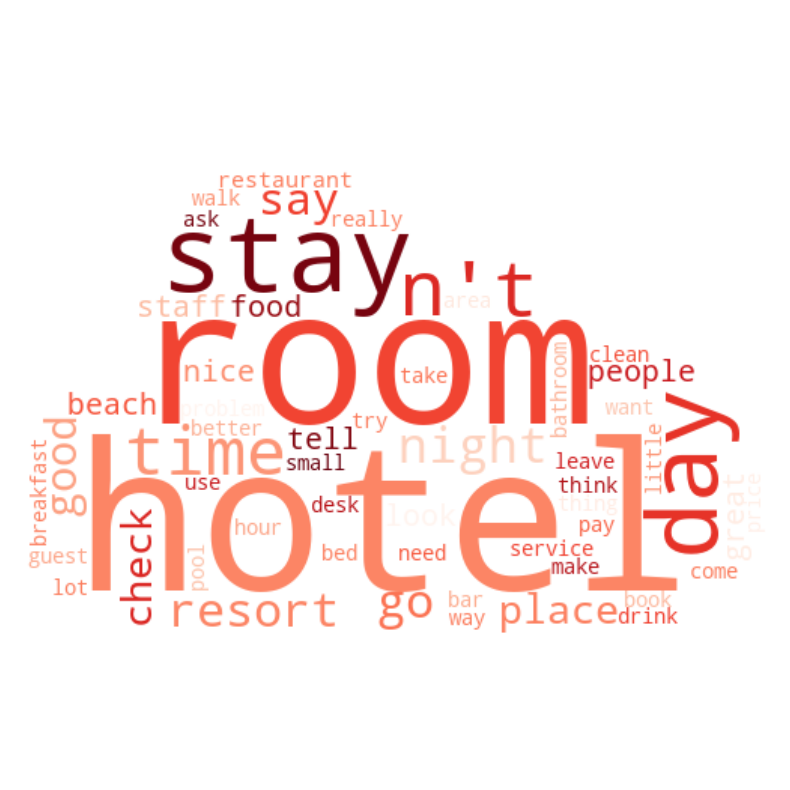

In [25]:
wordCloud_generator(df_bad, 'white', 'Reds')

<a id="5"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Building Model with Sklearn Classifiers Models</span></b></h1>

In [26]:
X = df['clean_review']
Y = df['score']

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Calculate the proportion of values in each set
train_proportions = y_train.value_counts() / len(y_train)
test_proportions = y_test.value_counts() / len(y_test)

print("Proportions in the training set:")
print(train_proportions)

print("\nProportions in the test set:")
print(test_proportions)

Proportions in the training set:
score
good    0.739873
bad     0.260127
Name: count, dtype: float64

Proportions in the test set:
score
good    0.722439
bad     0.277561
Name: count, dtype: float64


In [28]:
X.head()

10726    recommend hotel reviewers actually stay hotel ...
14919    barcelona rock stay hotel jazz girlfriend nigh...
19098    ok hotel good location stay night way beijing ...
2450     great service nice pool ok beach lovely ground...
960      surprise treat spend weekend july cartwright h...
Name: clean_review, dtype: object

In [29]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Class Mapping:", class_mapping)

Class Mapping: {0: 'bad', 1: 'good'}


In [30]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

##### Save the transformer 

In [31]:
import pickle

pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [32]:
models = [DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          XGBClassifier(random_state=42),
          SVC(random_state=42),
          LogisticRegression(random_state=42, max_iter=1000),
          KNeighborsClassifier()]

In [33]:
from sklearn.model_selection import cross_val_score

accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train_encoded, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [34]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.773675
1,RandomForestClassifier,0.824793
2,XGBClassifier,0.876648
3,SVC,0.891534
4,LogisticRegression,0.886777
5,KNeighborsClassifier,0.803566


After comparing the performance of various classifiers, the SVC emerges as the top performer with the highest accuracy. However, I want to improve further the XGBoost classifier as the preferred model for training the reviews sentiment analysis. 

In [35]:
best_model = XGBClassifier(random_state=42)
best_model.fit(train_tfid_matrix, y_train_encoded)
pred = best_model.predict(test_tfid_matrix)

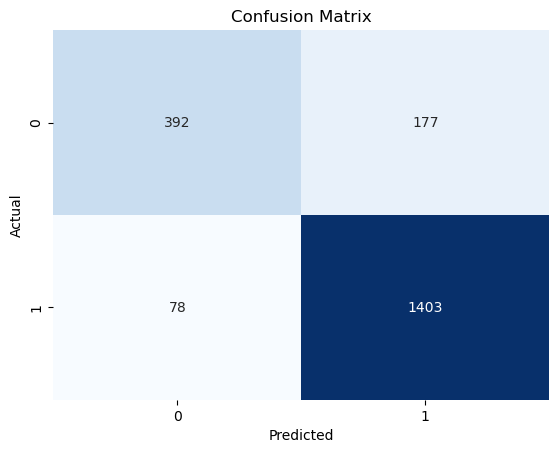

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test_encoded, pred)

# Plot confusion matrix as a heatmap
sns.heatmap(cf, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
from sklearn.metrics import classification_report


cr = classification_report(y_test_encoded, pred)
print(f'Classification Report: {cr}')

Classification Report:               precision    recall  f1-score   support

           0       0.83      0.69      0.75       569
           1       0.89      0.95      0.92      1481

    accuracy                           0.88      2050
   macro avg       0.86      0.82      0.84      2050
weighted avg       0.87      0.88      0.87      2050



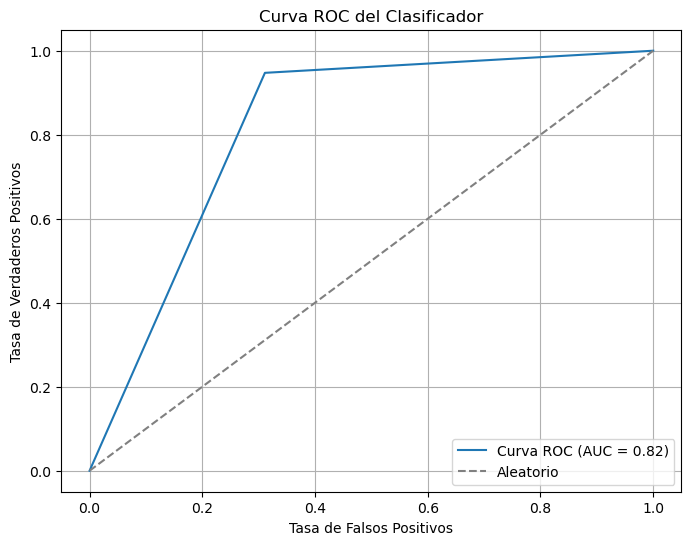

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_encoded, pred)  # Calcular la tasa de falsos positivos (FPR) y la tasa de verdaderos positivos (TPR)
roc_auc = auc(fpr, tpr)  # Calcular el área bajo la curva (AUC)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Clasificador')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


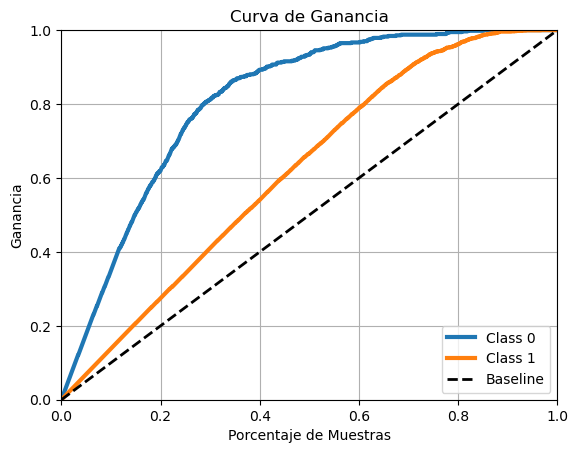

In [39]:
import scikitplot as skplt

probs = best_model.predict_proba(test_tfid_matrix)
skplt.metrics.plot_cumulative_gain(y_test_encoded, probs)
plt.xlabel('Porcentaje de Muestras')
plt.ylabel('Ganancia')
plt.title('Curva de Ganancia')
plt.grid(True)
plt.show()


In [40]:
pickle.dump(best_model, open('ml_model.pkl', 'wb'))

#### Open the model trained and the transformed values used during training

In [41]:
ml = pickle.load(open('ml_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))

In [42]:
def ml_predict(text):
    text = clean_text(text)
    tfid_matrix = tfidf.transform([text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]
    
    return pred, pred_proba[0][idx]

ml_predict('poor room service')

(0, 0.9569261)

### SHAP Values

In [43]:
explainer = shap.TreeExplainer(best_model)

/usr/local/anaconda3/envs/nlp/lib/python3.8/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



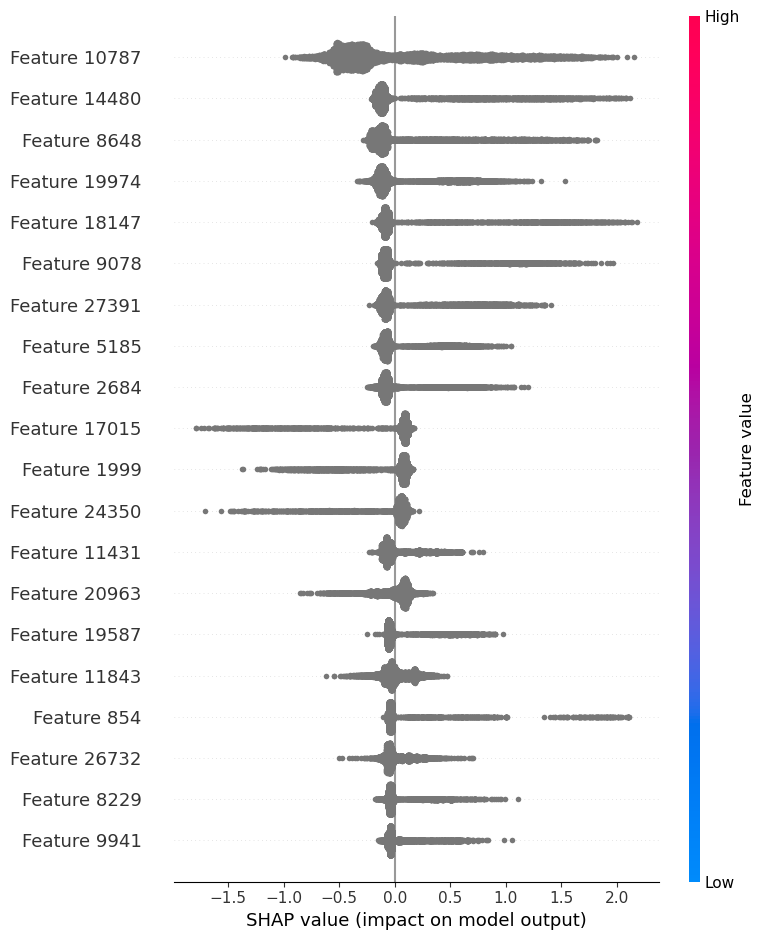

In [44]:
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(train_tfid_matrix)

# Visualize the SHAP values
shap.summary_plot(shap_values, train_tfid_matrix)

<a id="6"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Predictions</span></b></h1>

In [55]:
text1 = 'I recently stayed at [Hotel Name] and unfortunately, my experience was far from satisfactory. The room services and wifi connection were major letdowns during my stay.Firstly, the room services were incredibly poor. The housekeeping staff seemed to have neglected their duties entirely'

print('Prediction using XGBoost: {}'.format(ml_predict(text1)))

Prediction using XGBoost: 0


In [57]:
text2 = 'The room was not properly cleaned upon my arrival, and despite multiple requests, the situation did not improve throughout my stay. The towels were not replaced, trash bins were left overflowing, and basic amenities were not replenished'

print('Prediction using XGBoost: {}'.format(ml_predict(text2)))

Prediction using XGBoost: 0


In [58]:
text3 = 'Hard to get here but the scenery is wonderful'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text3)))

Prediction using Logistic Regression: 1
